# Off-policy / Counterfactual learning

### About this notebook
Understanding how to apply counterfactual learning approaches in practise can be overwhelming. 

In this notebook, we show that applying these techniques is actually quite straightforward if you are already familiar with basic Machine Learning methods. 

The notebook introduces an environment where our goal is to optimise an existing policy (model) using Bandit feedback. For example, this could represent a scenario where we want to place a banner on our website displaying a specific product with our feedback being whether users click on this banner. 

In our simulation, we have an existing that is sub-optimal and find ways to improve the model performance using counterfactual learning techniques. 

#### What you will learn by going through this notebook
1. How do we apply Inverse Propensity Weighting (IPW) in a realistic environment.
1. How does randomisation affect the learning capability of new models.
1. How can we measure whether randomisation is sufficient for IPW to do it's job.

In [9]:
from collections import defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RandomForest

from obp.policy import LinEpsilonGreedy
from obp.simulator.simulator import BanditEnvironmentSimulator, BanditPolicySimulator
from obp.dataset import logistic_polynomial_reward_function



### 1. Setting up the environment in Open Bandit Pipelines
The simulation uses [Open Bandit Pipeline](https://github.com/st-tech/zr-obp) for generating an environment. The environment defines how many arms (eg. unique recommendable banners) and context (features/user characteristics) we have, and how the reward is defined.

In [10]:
n_actions = 9
dim_context = 3

env = BanditEnvironmentSimulator(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_type="binary", 
    reward_function=logistic_polynomial_reward_function,
    random_state=12345,
)

### 2. Warming up a logging policy
In this simulation, we create a logging policy that was trained on a small dataset. This create a policy that is much better than random, but could definitely be improved.

In [11]:
pre_train_rounds = 100
data_collection_rounds = 100000
evaluation_rounds = 100000

base_policy = LinEpsilonGreedy(n_actions=n_actions, dim=dim_context, epsilon=1.0, random_state=12345)
warmup_simulator = BanditPolicySimulator(policy=base_policy)
warmup_simulator.steps(batch_bandit_rounds=env.next_bandit_round_batch(n_rounds=pre_train_rounds))

100%|██████████| 100/100 [00:00<00:00, 48293.66it/s]


### 3. Logging data and collecting propensities
#### Logging policy
Using the logging policy, we can create logs that can be used for future model iterations. However, applying the model greedly, would result into biased data. To overcome this bias, we need to both create some stochasticity during logging and apply counterfactual learning techniques such as IPW for training. 

In the next cell, we run our logging policy with various levels of epsilon. The $\epsilon$ parameter refers to the fraction of traffic where the action is sampled as uniform random, $1 - \epsilon$ is the fraction of traffic being served greedy results from our logging policy.

#### Collecting propensities
In the same loop, we also compute the propensities of our logging policy using a regression method similar to [Hanna Josiah et al. - "Importance sampling policy evaluation with an estimated behavior policy](http://proceedings.mlr.press/v97/hanna19a/hanna19a.pdf).

Another method would be to log the propensity on inference time. 

In [12]:
training_epsilons = [.01, .05, .10, .2, .5, .8, 1.0]
training_logs = defaultdict(list)

# Next we disable updates and reduce the epsilon parameter to create a logging policy
# This policy represents a situation with a suboptimal logging policy
training_rounds = env.next_bandit_round_batch(n_rounds=data_collection_rounds)
for epsilon in training_epsilons:
    base_policy.update_params = lambda **x: None
    base_policy.epsilon = epsilon

    # We create a training period where the logging policy creates usable logs for counterfactual evaluation and optimisation
    # TODO: Can we log propensities here easily?
    training_simulator = BanditPolicySimulator(policy=base_policy)
    training_simulator.steps(batch_bandit_rounds=training_rounds)

    # Train a propensity model on the actions in the training period to get propensities per round
    propensity_model = LogisticRegression(random_state=12345)
    propensity_model.fit(training_simulator.contexts, training_simulator.selected_actions)
    p_scores = propensity_model.predict_proba(training_simulator.contexts)
    # TODO Corrupt: Use different features than target/logging policy
    # TODO Corrupt: Smooth propensities eg. constant and then re-normalize
    # TODO Corrupt using a very overfitted model and solve the problem with SNIPS

    training_logs[f"{epsilon}"] = {"simulator": training_simulator, "p_scores": p_scores}



100%|██████████| 100000/100000 [00:00<00:00, 103591.91it/s]


### 4. Optimising and evaluating new policies
Using the logged data created in the previous section, we should be able to create new policies and evaluate them on new traffic. 

#### Optimising a Naive and IPW model
We optimise our polices using both a Naive method (no debiasing), and using IPW. In IPW we simply divide our training target by the propensities estimated in the previous section to get the desired effect.

To evaluate these policies, we also pull a new batch of rounds from the environment. This simulates the effect of deploying your policy on new incoming traffic and observing the average reward. 


In [13]:
# Pull a batch of full-information data to act as the environment
evaluation_data = env.next_bandit_round_batch(n_rounds=evaluation_rounds)

results = pd.DataFrame({'epsilon': [], 'Total Reward in stage': [] , "Average Reward": []})
models = defaultdict(list)

def fit_model(logs, sample_weights):
    model = RandomForest(n_estimators=30, min_samples_leaf=10, random_state=12345)
    model.fit(
        logs["simulator"].contexts,
        logs["simulator"].selected_actions,
        sample_weight=sample_weights
    )
    predicted_actions = model.predict(evaluation_data.context)
    mean_evaluation_reward = np.sum(np.eye(n_actions)[predicted_actions] * evaluation_data.rewards) / logs["simulator"].contexts.shape[0]
    return mean_evaluation_reward    


for name, logs in training_logs.items():
    naive_sample_weights = logs["simulator"].obtained_rewards
    mean_naive_reward = fit_model(logs, naive_sample_weights)
    
    # Transforming a naive model into an IPW model is as simply as dividing the reward by the propensity of the logging policy.
    ipw_samples_weights = naive_sample_weights / np.choose(logs["simulator"].selected_actions, logs["p_scores"].T + 1e-10)
    mean_ipw_reward = fit_model(logs, ipw_samples_weights)
    
    mean_logging_reward = logs["simulator"].total_reward / logs["simulator"].rounds_played 

    experiment_outcome = pd.DataFrame({
        'epsilon': 3 * [name],
        'Total Reward in stage': ["Data collection", "Model exploit (IPW)", "Model exploit (Naive)"],
        "Average Reward": [mean_logging_reward, mean_ipw_reward, mean_naive_reward],
    })
    results = pd.concat([results, experiment_outcome], ignore_index=True)


### Computing control variates
Before we draw any conclusions about the actual performance of our new policy, we need to have some measurement of quality for the logging policy. One method of approximating this is using the control variates from [Ben London et al. Control variate diagnostics for detecting problems in logged bandit feedback](https://assets.amazon.science/42/64/55e29303474497273d4b86af85ea/control-variate-diagnostics-for-detecting-problems-in-logged-bandit-feedback.pdf).

$$ CV(\pi_{e}, S) = \frac{1}{n}\sum^{n}_{i=1} \frac{\pi_{e}(a_i|x_i)}{p_i}$$

In the cell below, we compute the control variates for a uniform random target policy. We want to ensure that our control variate is close to 1, if not we have an indication that there was either insufficient randomisation or a error in computing the propensities. 



In [14]:
_control_variate = defaultdict(list)
for name, logs in training_logs.items():
    _control_variate["epsilon"].append(float(name))
    _control_variate["control variate"].append(np.mean((1/n_actions) / np.choose(logs["simulator"].selected_actions, logs["p_scores"].T)))

control_variate = pd.DataFrame(_control_variate)


In [15]:
control_variate

,epsilon,control variate
0,0.01,1.880516e+29
1,0.05,2.606883e+09
2,0.10,5.785985e+04
3,0.20,5.423647e+01
4,0.50,1.304027e+00
5,0.80,1.011202e+00
6,1.00,9.999968e-01


### 5. Results
In the figure below, we can make a few observations.

#### Our choice of epsilon matters
Increasing our epsilon has a couple of effects:

*The average reward of our logging policy goes down.* Which is expected as a larger share of the traffic is now uniform random.
*The future average reward of our updated (IPW/Naive) models is going up.* This shows that future performance can be "bought" by leveraging randomisation in our logging policy

#### Propensity weighting matters
*The performance of the IPW model is significantly higher when epsilon is low.* Using IPW methods, therefor allows you to achieve similar performance which less exploration.

#### Our choice of epsilon can be validated*  using control variates
*The control variates are inversely correlated with the IPW model performance.* This means that even without evaluating the policy on real traffic, we can get an understanding whether the IPW performance is unbiased and are therefor expected to allow optimal results given the available traffic. 

\* We cannot truly validate the choice, but we can make an educated guess using the control variates

/tmp/ipykernel_105344/1500466285.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='center left', bbox_to_anchor=(1, 1.0))


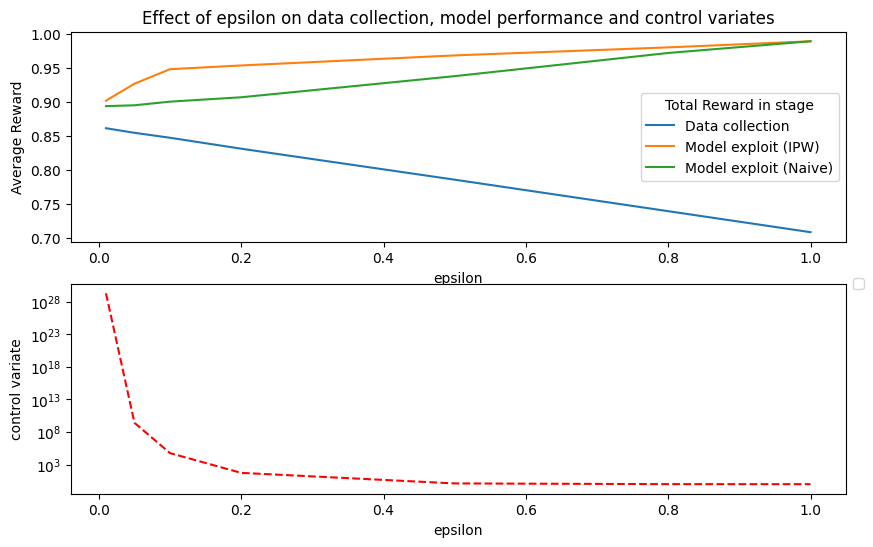

In [16]:
import matplotlib.pyplot as plt

results['epsilon'] = pd.to_numeric(results['epsilon'])
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 6))

(
    sns
    .lineplot(data=results, x="epsilon", y="Average Reward", hue="Total Reward in stage", errorbar='sd', ax=ax1)
    .set_title('Effect of epsilon on data collection, model performance and control variates')
)
sns.lineplot(data=control_variate, x="epsilon", y="control variate", color="red", errorbar='sd', ls="--", ax=ax2)
ax2.legend(loc='center left', bbox_to_anchor=(1, 1.0))
ax2.set_yscale("log")


### Conclusion
This notebook has shown how simple it can be to train a model using off-policy / counterfactual techniques. Moreover, we show how stochasticity affects the ability to use these techniques, and how methods such as control variates allow you to get some basic estimate of whether your logged data is sufficient.